In [2]:
import numpy
import pandas
from astropy import units
from galpy.util import bovy_coords, bovy_plot
import gaia_tools.load as gload
import gaia_tools.xmatch
from gaia_tools import query
import matplotlib.colors as mcolors

from misc import bootstrap
%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


# Median Vertical Velocities

## Using GALAH

In [43]:
vsun= 7.25

In [44]:
galah,gaia2_matches= gload.galah(dr=2,xmatch='gaiadr2',gaia_all_columns=True)

Compute Galactic coordinates:

In [45]:
lb_g= bovy_coords.radec_to_lb(gaia2_matches['ra'].to(units.deg).value,gaia2_matches['dec'].to(units.deg).value,degree=True)
XYZ_g= bovy_coords.lbd_to_XYZ(lb_g[:,0],lb_g[:,1],1./gaia2_matches['parallax'],degree=True)
Rxy_g= numpy.sqrt(XYZ_g[:,0]**2.+XYZ_g[:,1]**2.)
pmllbb_g= bovy_coords.pmrapmdec_to_pmllpmbb(gaia2_matches['pmra'],gaia2_matches['pmdec'],
                                         gaia2_matches['ra'],gaia2_matches['dec'],degree=True)
UVW_g= bovy_coords.vrpmllpmbb_to_vxvyvz(galah['rv_obst'],pmllbb_g[:,0],pmllbb_g[:,1],
                                      lb_g[:,0],lb_g[:,1],1./gaia2_matches['parallax'],degree=True)

Cut to good parallaxes and stars within 2 kpc from the Sun (in projection onto the plane):

In [46]:
indx_g= (gaia2_matches['parallax']/gaia2_matches['parallax_error'] > 5.)\
    *(Rxy_g < 2.)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)



The vertical (W) velocities are then (running median given as the black line)

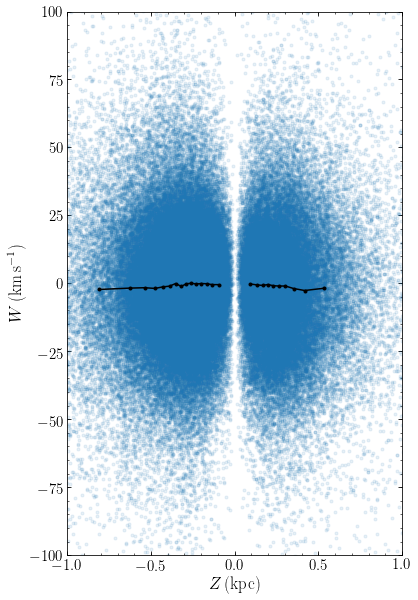

In [47]:
bovy_plot.bovy_plot(XYZ_g[indx_g,2],UVW_g[indx_g,2]+vsun,'.',alpha=0.1,
                    xrange=[-1.,1.],
                    yrange=[-100.,100.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')
sindx_g= numpy.argsort(XYZ_g[indx_g,2])
wind_g= 10000
showskip_g= wind_g
running_median_galah= pandas.DataFrame(UVW_g[indx_g,2][sindx_g]+vsun)\
        .rolling(window=wind_g,center=True,min_periods=wind_g//2)\
        .apply(func=lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ_g[indx_g,2][sindx_g][::showskip_g],running_median_galah[::showskip_g],
     'k.-')

We can also estimate the uncertainty on the running median as:

In [48]:
running_median_err_galah= pandas.DataFrame(UVW_g[indx_g,2][sindx_g]+vsun)\
        .rolling(window=wind_g,center=True,min_periods=wind_g//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))),raw=True)

The running median and its error:

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)



<Container object of 3 artists>

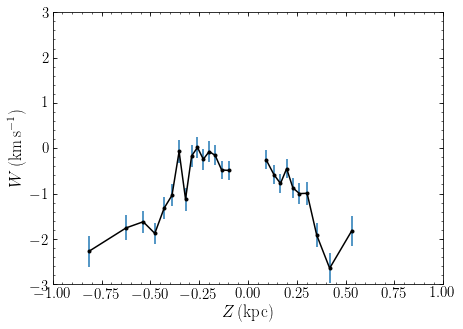

In [50]:
figsize(7,5)
bovy_plot.bovy_plot(XYZ_g[indx_g,2][sindx_g][::showskip_g],running_median_galah[::showskip_g],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                    xlabel=r'$Z\,(\mathrm{kpc})$',
                    ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')
errorbar(XYZ_g[indx_g,2][sindx_g][::showskip_g],numpy.array(running_median_galah[::showskip_g]),
         yerr=numpy.array(running_median_err_galah[::showskip_g]),
         marker='None',ls='None')

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.



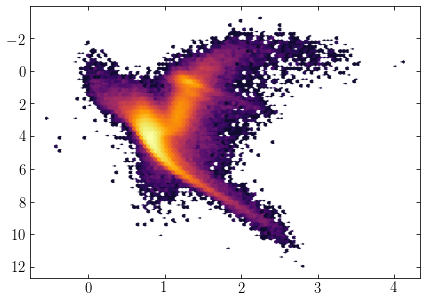

In [51]:
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

MG= -5*log(1000/gaia2_matches['parallax'])/log(10)+5+gaia2_matches['phot_g_mean_mag']
hexbin(gaia2_matches['bp_rp'][indx_g][sindx_g],MG[indx_g][sindx_g],bins='log',cmap=cmap)

gca().invert_yaxis()

## Using APOGEE

Next, we do the same for APOGEE. Load the data:

In [52]:
apogee,apgaia2_matches= gload.apogee(xmatch='gaiadr2',gaia_all_columns=True)
apgaia2_matches= numpy.array(apgaia2_matches)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/gaia_tools-0.2-py3.6.egg/gaia_tools/load/__init__.py:73: UserWarning: Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package
  warnings.warn("Falling back on simple APOGEE interface; for more functionality, install the jobovy/apogee package")



Convert coordinates:

In [53]:
lb_a= bovy_coords.radec_to_lb(apgaia2_matches['ra'],apgaia2_matches['dec'],degree=True)
XYZ_a= bovy_coords.lbd_to_XYZ(lb_a[:,0],lb_a[:,1],1./apgaia2_matches['parallax'],degree=True)
Rxy_a= numpy.sqrt(XYZ_a[:,0]**2.+XYZ_a[:,1]**2.)
pmllbb_a= bovy_coords.pmrapmdec_to_pmllpmbb(apgaia2_matches['pmra'],apgaia2_matches['pmdec'],
                                         apgaia2_matches['ra'],apgaia2_matches['dec'],degree=True)
UVW_a= bovy_coords.vrpmllpmbb_to_vxvyvz(apogee['VHELIO_AVG'],pmllbb_a[:,0],pmllbb_a[:,1],
                                      lb_a[:,0],lb_a[:,1],1./apgaia2_matches['parallax'],degree=True)

Only keep stars with good parallaxes:

In [54]:
tindx_a= (apgaia2_matches['parallax']/apgaia2_matches['parallax_error'] > 5.)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.



X vs. Z now (much closer to the plane!):

Only keep stars within 500 pc projected onto the plane:

In [55]:
indx_a= (apgaia2_matches['parallax']/apgaia2_matches['parallax_error'] > 5.)\
    *(Rxy_a < .5)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.



The vertical (W) velocities and their running median are:

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':



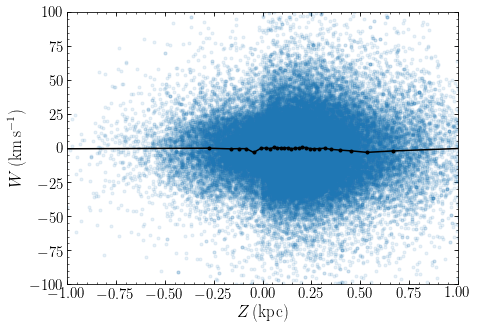

In [56]:
bovy_plot.bovy_plot(XYZ_a[indx_a,2],UVW_a[indx_a,2]+vsun,'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                   
sindx_a= numpy.argsort(XYZ_a[indx_a,2])
wind_a= 3000
showskip_a= wind_a
running_median_apogee= pandas.DataFrame(UVW_a[indx_a,2][sindx_a]+vsun)\
        .rolling(window=wind_a,center=True,min_periods=wind_a//2)\
        .apply(lambda x: numpy.nanmedian(x))
plot(XYZ_a[indx_a,2][sindx_a][::showskip_a],running_median_apogee[::showskip_a],
     'k.-')

Estimate the uncertainty:

In [57]:
running_median_err_apogee= pandas.DataFrame(UVW_a[indx_a,2][sindx_a]+vsun)\
        .rolling(window=wind_a,center=True,min_periods=wind_a//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))))

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.



The median vertical velocity vs. Z:

<Container object of 3 artists>

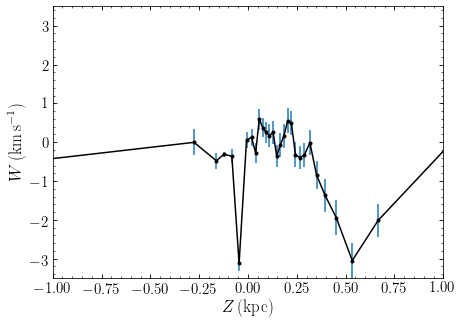

In [58]:
bovy_plot.bovy_plot(XYZ_a[indx_a,2][sindx_a][::showskip_a],running_median_apogee[::showskip_a],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.5,3.5],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                    
errorbar(XYZ_a[indx_a,2][sindx_a][::showskip_a],numpy.array(running_median_apogee[::showskip_a]),
         yerr=numpy.array(running_median_err_apogee[::showskip_a]),
         marker='None',ls='None')

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.



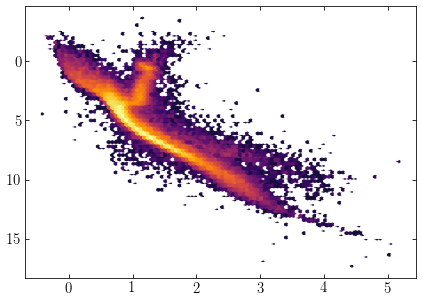

In [59]:
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

MG= -5*log(1000/apgaia2_matches['parallax'])/log(10)+5+apgaia2_matches['phot_g_mean_mag']
hexbin(apgaia2_matches['bp_rp'][indx_a],MG[indx_a],bins='log',cmap=cmap)

gca().invert_yaxis()

## Using the *Gaia* DR2 RV sample


In [17]:
velquery= '''SELECT radial_velocity, radial_velocity_error, phot_g_mean_mag, bp_rp,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr2.gaia_source
WHERE radial_velocity IS NOT Null AND parallax_over_error>5.
AND parallax IS NOT Null'''

In [18]:
out= query.query(velquery,local=False)
query.cache.nickname(velquery,'velq')

True

In [19]:
lb= bovy_coords.radec_to_lb(array(out['ra']),array(out['dec']),degree=True)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],1./out['parallax'],degree=True)
Rxy= numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(out['pmra'],out['pmdec'],
                                         out['ra'],out['dec'],degree=True)
UVW= bovy_coords.vrpmllpmbb_to_vxvyvz(out['radial_velocity'],pmllbb[:,0],pmllbb[:,1],
                                      lb[:,0],lb[:,1],1./out['parallax'],degree=True)

In [20]:
tindx= (out['parallax']/out['parallax_error'] > 5.)

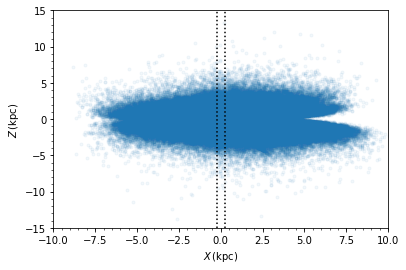

In [36]:
bovy_plot.bovy_plot(XYZ[:,0],XYZ[:,2],
                    '.', alpha=0.05,
                    xrange=[-10.,10.],
                    yrange=[-15.,15.],
                   xlabel=r'$X\,(\mathrm{kpc})$',
                   ylabel=r'$Z\,(\mathrm{kpc})$')  

axvline(-0.25,color='k',ls=':')
axvline(0.25,color='k',ls=':')

In [37]:
indx= (Rxy < .25)

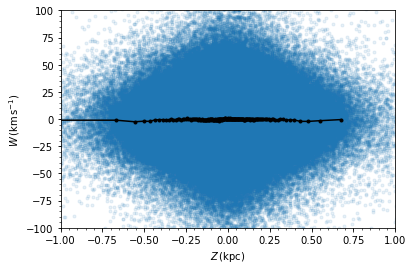

In [12]:
bovy_plot.bovy_plot(XYZ[indx,2],UVW[indx,2]+vsun,'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')   
sindx= numpy.argsort(XYZ[indx,2])
wind= 5000
showskip= wind
running_median_gaia= pandas.DataFrame(UVW[indx,2][sindx]+vsun)\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
     'k.-')

In [13]:
running_median_err_gaia= pandas.DataFrame(UVW[indx,2][sindx]+vsun)\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))))

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.



<Container object of 3 artists>

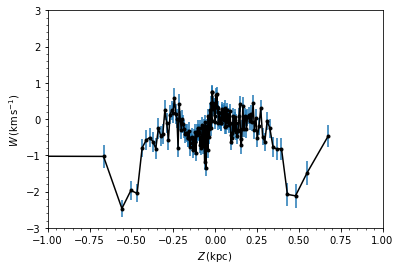

In [14]:
bovy_plot.bovy_plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                    
errorbar(XYZ[indx,2][sindx][::showskip],numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')

In [38]:
binw1= 0.025
binw2= 0.1
bins= append(append(numpy.round(arange(-1.5,-0.5,binw2),2),
                    numpy.round(arange(-0.5,0.5+binw1,binw1),3)),
             numpy.round(arange(0.5+binw2,1.5+binw2,binw2),2))

vave= zeros(len(bins)-1)
vave_b= zeros(len(bins)-1)
sig= zeros(len(bins)-1)
sig_b= zeros(len(bins)-1)

for i in range(len(bins)-1):
    print(i)
    sample= UVW[indx,2][(XYZ[indx,2]>bins[i])*(XYZ[indx,2]<bins[i+1])]+vave)
    vave[i]= median(sample)
    vave_b[i], sig_b[i]= bootstrap(sample,10000)
    sig[i]= 1.4826*median(abs(sample-numpy.nanmedian(sample)))/sqrt(len(sample))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  



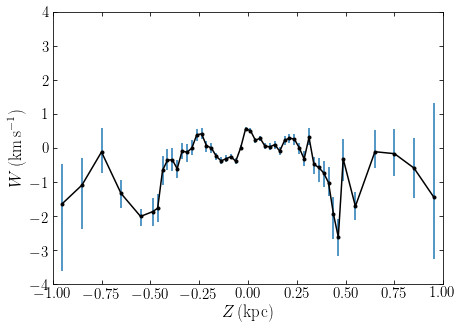

In [76]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(7,5)

mid= (bins[1:]+bins[:-1])/2.
mask= [(mid<1)*(mid>-1)]
plot(mid[mask],vave[mask],'k.-')
errorbar(mid[1:-1],vave_b[1:-1],yerr=sig_b[1:-1],marker='None',ls='None')
xlim([-1,1])
ylim([-4,4])

xlabel(r'$Z\,(\mathrm{kpc})$')
ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

np.save('bin_vel', [mid[mask],vave[mask],sig_b[mask]])

(-0.008659452435661744, 0.06757313819852868)


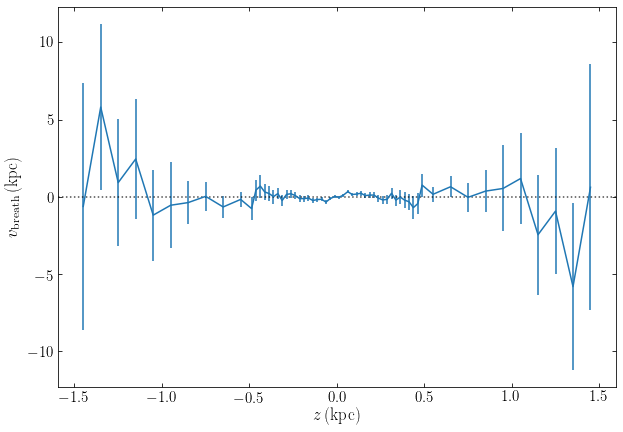

In [41]:
figsize(10,7)

mid= (bins[1:]+bins[:-1])/2.
errorbar(mid,(vave_b-vave_b[::-1])/2.,sqrt(sig_b**2+sig_b[::-1]**2))
axhline(0.,color='k',ls=':',alpha=0.7)
xlabel(r'$z\,\mathrm{(kpc)}$')
ylabel(r'$v_\mathrm{breath}\,\mathrm{(kpc)}$')
savefig('breath.png')

print(bootstrap((vave_b-vave_b[::-1])/2.,10000))

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)



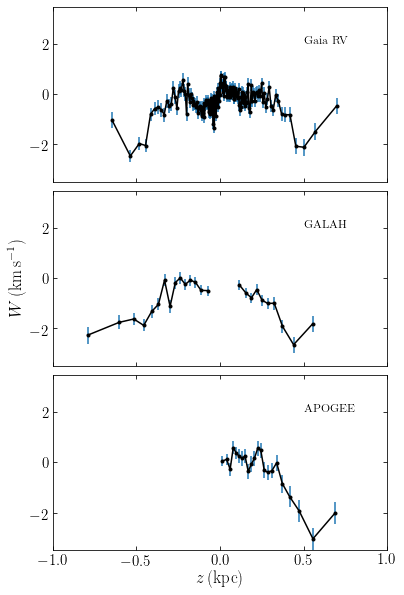

In [61]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,10)

fig, (ax1,ax2,ax3)= subplots(3,sharex=True)
fig.subplots_adjust(hspace=0.05)

ax1.text(0.5,2,r'$\mathrm{Gaia\,\,RV}$')
ax2.text(0.5,2,r'$\mathrm{GALAH}$')
ax3.text(0.5,2,r'$\mathrm{APOGEE}$')

ax2.plot(XYZ_g[indx_g,2][sindx_g][::showskip_g]+0.0209,running_median_galah[::showskip_g],'k.-')
ax2.errorbar(XYZ_g[indx_g,2][sindx_g][::showskip_g]+0.0209,numpy.array(running_median_galah[::showskip_g]),
         yerr=numpy.array(running_median_err_galah[::showskip_g]),
         marker='None',ls='None')

z_a=XYZ_a[indx_a,2][sindx_a][::showskip_a]+0.0209
ax3.plot(z_a[z_a>0][:-1],running_median_apogee[::showskip_a][z_a>0][:-1],'k.-')                    
ax3.errorbar(z_a[z_a>0][:-1],numpy.array(running_median_apogee[::showskip_a][z_a>0])[:-1],
         yerr=numpy.array(running_median_err_apogee[::showskip_a][z_a>0][:-1]),
         marker='None',ls='None')

ax1.plot(XYZ[indx,2][sindx][::showskip][1:]+0.0209,running_median_gaia[::showskip][1:],'k.-')
ax1.errorbar(XYZ[indx,2][sindx][::showskip]+0.0209,numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')
ax3.set_xlim([-1.,1.])
ax3.set_xlabel(r'$z\,(\mathrm{kpc})$')
ax2.set_ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

for a in [ax1,ax2,ax3]:
    a.set_ylim([-3.5,3.5])
    a.set_yticks([-2,0,2])
    
savefig('3vel.pdf',bbox_inches='tight')

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log



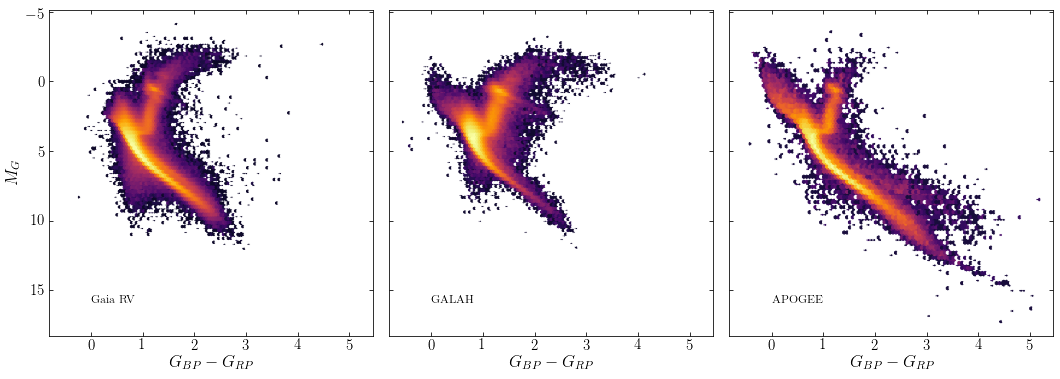

In [46]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(18,6)
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

fig,(ax1,ax2,ax3) = subplots(1,3,sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.05)

ax1.text(0,16,r'$\mathrm{Gaia\,\,RV}$')
ax2.text(0,16,r'$\mathrm{GALAH}$')
ax3.text(0,16,r'$\mathrm{APOGEE}$')

MGGG= -5*log(1000/gaia2_matches['parallax'])/log(10)+5+gaia2_matches['phot_g_mean_mag']
ax2.hexbin(gaia2_matches['bp_rp'][indx_g],MGGG[indx_g],bins='log',cmap=cmap)
ax2.invert_yaxis()

MGA= -5*log(1000/apgaia2_matches['parallax'])/log(10)+5+apgaia2_matches['phot_g_mean_mag']
ax3.hexbin(apgaia2_matches['bp_rp'][indx_a],MGA[indx_a],bins='log',cmap=cmap)
ax3.invert_yaxis()

MGG= -5*log(1000/out['parallax'])/log(10)+5+out['phot_g_mean_mag']
ax1.hexbin(out['bp_rp'][indx],MGG[indx],bins='log',cmap=cmap)
ax1.invert_yaxis()

ax1.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax3.set_xlabel(r'$G_{BP}-G_{RP}$')
ax1.set_ylabel(r'$M_G$')

savefig('CMD_vel.pdf',bbox_inches='tight')